In [2]:
import torch
mps_device = torch.device("mps")

# Load Data

2025-03-05 21:39:54.268381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


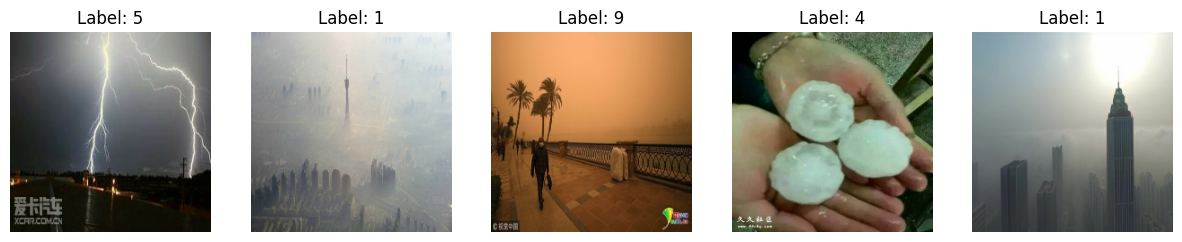

In [1]:
import pathlib
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, IncrementalPCA
import keras
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset/hyperparams
sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
batch_size = 32
image_size = (224, 224) #do not change for resnet50

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

### USE THESE 
train_dataset, val_dataset = dataset  

# print first 5 of training set
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].numpy()}")
    plt.show()
    break

# Data Augmentation

In [56]:
# Get X_train and y_train data
X_train = []
y_train = []
for images, labels in train_dataset:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Augment training images
datagen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Append augmented data to X_train and y_train
augmented_data = datagen.flow(X_train, y_train, batch_size=32)
augmented_X_train = []
augmented_y_train = []
for i in range(len(X_train) // 32):  # Adjust the range as needed
    batch_X, batch_y = next(augmented_data)
    augmented_X_train.append(batch_X)
    augmented_y_train.append(batch_y)
augmented_X_train = np.concatenate(augmented_X_train, axis=0)
augmented_y_train = np.concatenate(augmented_y_train, axis=0)

# Normalize X_train and X_train combine
X_train_summed = X_train.sum(axis=3) / 255.0
augmented_X_train_summed = augmented_X_train.sum(axis=3) / 255.0

# Combine original and augmented data 
X_train_combined = np.concatenate((X_train, augmented_X_train), axis=0)
y_train_combined = np.concatenate((y_train, augmented_y_train), axis=0)

print(X_train_combined.shape)
print(y_train_combined.shape)


2025-03-05 21:02:37.784059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-03-05 21:02:38.960652: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-03-05 21:02:41.490961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-03-05 21:02:44.062738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(10962, 224, 224, 3)
(10962,)


# PCA

2025-03-05 21:40:18.803458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-03-05 21:40:20.140228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-03-05 21:40:21.033525: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-03-05 21:40:22.555295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-05 21:40:30.906964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of principal components explaining 95% of variance: 1204


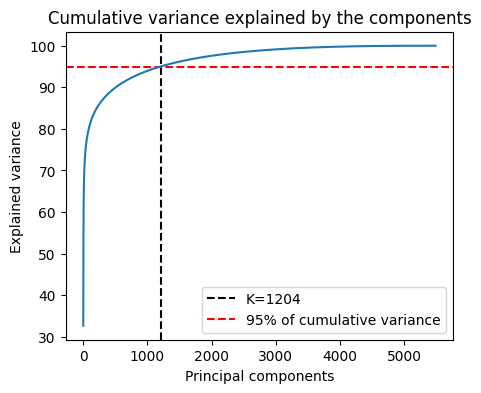

In [2]:
# Get X_val and y_val, normalize
X_train, y_train = [], []
for images, labels in train_dataset:
    X_train.append((images.numpy() / 255.0))
    y_train.append(labels.numpy())
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

X_val, y_val = [], []
for images, labels in val_dataset:
    X_val.append((images.numpy() / 255.0))
    y_val.append(labels.numpy())
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)


# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)  

# Create instance of PCA and fit
pca = PCA()
pca.fit_transform(X_train_flat)

# Find cumulative variance
var_cum = np.cumsum(pca.explained_variance_ratio_) * 100

# How many principal components explain 95% of the variance?
k = np.argmax(var_cum > 95) + 1  # +1 because np.argmax returns the first index where condition is met
print("Number of principal components explaining 95% of variance: " + str(k))

# Plot cumulative variance
plt.figure(figsize=[5, 4])
plt.title('Cumulative variance explained by the components')
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--", label=f"K={k}")
plt.axhline(y=95, color="r", linestyle="--", label="95% of cumulative variance")
plt.plot(var_cum)
plt.legend()
plt.show()

In [3]:
# re run PCA using chosen k = 1200 for easier image reconstruction (20 x 20 = 400 * 3 = 1200)
pca = PCA(n_components=1200) 
X_train = pca.fit_transform(X_train_flat)
X_val = pca.transform(X_val_flat)

# Get principal components
principal_Df = pd.DataFrame(data = X_train,)
principal_Df['Label'] = y_train
print(principal_Df.head())

# Variance of principal components
print('Explained Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))


            0          1          2          3          4          5  \
0   22.595806  20.312172  10.180464   3.804279  14.271236  -0.473640   
1 -155.947327  15.272328   8.030163  14.572600  13.420838  14.395355   
2   -3.808069 -93.573784 -29.058197  -4.187716  -5.792556 -30.288671   
3  108.265282   0.864449   0.219033  12.911620 -10.929674   3.825993   
4   10.676601 -38.234325 -14.424792  52.453457 -12.695934   6.992543   

          6          7          8          9  ...      1191      1192  \
0 -1.569397  -4.953344   4.874023   0.294041  ...  0.319647 -0.061619   
1  8.670039  -2.016644   9.118158  -1.601396  ... -0.067402 -1.365432   
2 -2.873523   7.805034  13.013792   5.688995  ...  0.462129 -0.074230   
3  5.174526  25.134398   3.022433  21.691946  ...  0.483187  0.205555   
4 -6.986252  -3.709040   8.649890  -7.484341  ...  0.335037 -0.370189   

       1193      1194      1195      1196      1197      1198      1199  Label  
0  0.418890  0.153953 -0.204983 -0.264313  0.00

In [4]:
print(f"Before PCA X_train.shape: {X_train_flat.shape}")
print(f"After PCA X_train.shape: {X_train.shape}")

Before PCA X_train.shape: (5490, 150528)
After PCA X_train.shape: (5490, 1200)


In [5]:
# Reshape images to (20,20) since 20*20 = 400*3 = 1200 (number of principal components/features)
img_rows, img_cols=20,20

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3) 
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 3) 
y_train = y_train.reshape(y_train.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

print(X_train.shape)
print(y_train.shape)

(5490, 20, 20, 3)
(5490, 1)


# CNN

In [6]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam


tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 3)), # kernel_regularizer=regularizers.l2(0.01)),  # Adjust input_shape
    BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), activation='relu'), # kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'), # kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    # layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
    

    layers.Flatten(), # Flatten the output before the dense layer
    layers.Dense(128, activation='relu'),# kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(11, activation='softmax')  # Adjust the number of units to match the number of classes
])
        
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
model_history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2195 - loss: 2.6017 - val_accuracy: 0.4454 - val_loss: 1.6434
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3491 - loss: 1.9488 - val_accuracy: 0.4727 - val_loss: 1.4749
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3982 - loss: 1.7685 - val_accuracy: 0.4954 - val_loss: 1.4271
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4271 - loss: 1.6780 - val_accuracy: 0.4945 - val_loss: 1.3762
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4322 - loss: 1.6082 - val_accuracy: 0.5018 - val_loss: 1.3823
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4480 - loss: 1.6318 - val_accuracy: 0.5392 - val_loss: 1.2971
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4617 - loss: 1.5606 - val_accuracy: 0.5328 - val_loss: 1.2678
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4958 - loss: 1.4882 - val_accu

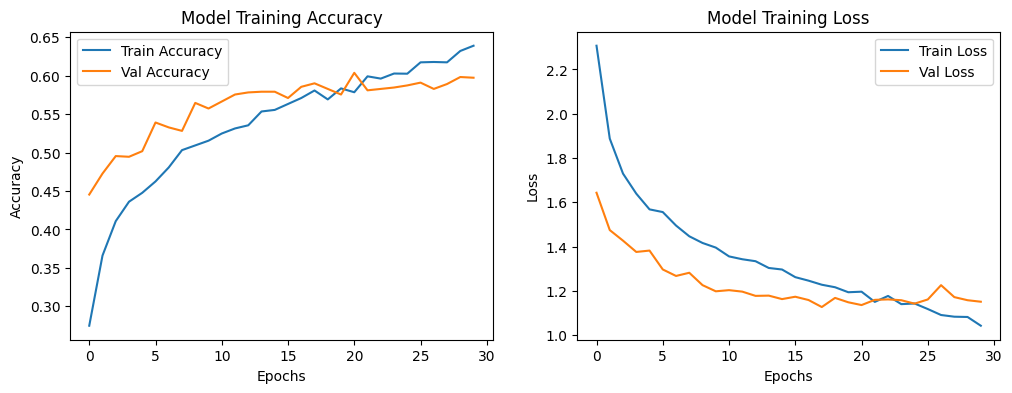

In [7]:
history = model_history.history
# Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Training Loss')

plt.show()

# Model Evaluation

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


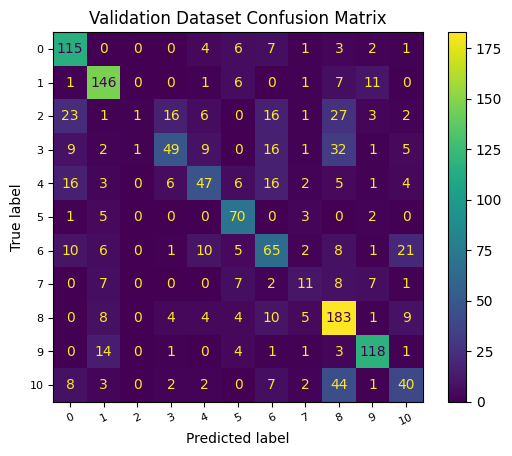

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
Y_val_pred = model.predict(x=X_val)
# Get the class with the highest probability for each sample
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
conf_matrix=confusion_matrix(y_val, Y_val_pred_classes)
# Plot confusion matrix
display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val))
display.plot()
plt.title("Validation Dataset Confusion Matrix")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=25)
plt.show()

In [54]:
print(classification_report(y_val, Y_val_pred_classes, target_names=[str(label) for label in np.unique(y_val)]))

              precision    recall  f1-score   support

           0       0.63      0.83      0.71       139
           1       0.75      0.84      0.79       173
           2       0.50      0.01      0.02        96
           3       0.62      0.39      0.48       125
           4       0.57      0.44      0.50       106
           5       0.65      0.86      0.74        81
           6       0.46      0.50      0.48       129
           7       0.37      0.26      0.30        43
           8       0.57      0.80      0.67       228
           9       0.80      0.83      0.81       143
          10       0.48      0.37      0.41       109

    accuracy                           0.62      1372
   macro avg       0.58      0.56      0.54      1372
weighted avg       0.60      0.62      0.58      1372



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = dataset.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

kfold = KFold(n_splits=5, shuffle=True)

# Initialize variables to store average metrics
avg_val_loss, avg_val_f1, avg_val_auc, avg_val_acc, avg_val_prec, avg_val_rec = 0, 0, 0, 0, 0, 0
all_true_labels, all_pred_labels = [], []

fold_no = 1

for train_index, val_index in kfold.split(len(train_dataset)):
    print(f"Training fold {fold_no}...")

    train_dataset = dataset.enumerate().filter(lambda i, _: tf.reduce_any(i == train_index)).map(lambda _, data: data)
    val_fold = dataset.enumerate().filter(lambda i, _: tf.reduce_any(i == val_index)).map(lambda _, data: data)
        
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax')
    ])
        
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall']
    )
        
    model.fit(train_dataset, epochs=10, validation_data=val_fold)

#     # Evaluate the model
#     val_loss, val_acc = model.evaluate(val_fold)
#     avg_val_loss += val_loss
#     avg_val_acc += val_acc

#     # Predict the labels
#     val_true_labels = []
#     val_pred_labels = []
#     for x, y in val_fold:
#         val_true_labels.extend(y.numpy())
#         val_pred_labels.extend(tf.argmax(model.predict(x), axis=1).numpy())

#     all_true_labels.extend(val_true_labels)
#     all_pred_labels.extend(val_pred_labels)

#     # Calculate metrics
#     avg_val_f1 += f1_score(val_true_labels, val_pred_labels, average='weighted')
#     avg_val_auc += roc_auc_score(val_true_labels, val_pred_labels, multi_class='ovr')
#     avg_val_prec += precision_score(val_true_labels, val_pred_labels, average='weighted')
#     avg_val_rec += recall_score(val_true_labels, val_pred_labels, average='weighted')

#     fold_no += 1

# # Compute average metrics
# avg_val_loss /= kfold.get_n_splits()
# avg_val_acc /= kfold.get_n_splits()
# avg_val_f1 /= kfold.get_n_splits()
# avg_val_auc /= kfold.get_n_splits()
# avg_val_prec /= kfold.get_n_splits()
# avg_val_rec /= kfold.get_n_splits()

# print(f"Average validation loss: {avg_val_loss}")
# print(f"Average validation accuracy: {avg_val_acc}")
# print(f"Average validation F1 score: {avg_val_f1}")
# print(f"Average validation AUC: {avg_val_auc}")
# print(f"Average validation precision: {avg_val_prec}")
# print(f"Average validation recall: {avg_val_rec}")


Epoch 1/10


ValueError: FBetaScore expects 2D inputs with shape (batch_size, output_dim). Received input shapes: y_pred.shape=(None, 11) and y_true.shape=(None,).